# Imports



In [ ]:
!pip install transformers rouge-score
!pip install fsspec==2024.10.0
!pip install gcsfs --upgrade
!pip install datasets
!pip install textstat
!pip install bert-score
!pip install transformers
!pip install wandb
!pip install evaluate

In [2]:
# Core Libraries
import os
import re
import time
import random
import warnings
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# Data Processing
from sklearn.model_selection import train_test_split
from datasets import Dataset

# NLTK (Natural Language Toolkit)
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Transformers
import torch
from transformers import (
    AutoTokenizer,
    BartForConditionalGeneration,
    PegasusTokenizer,
    PegasusForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    TrainerCallback,
    pipeline,
)

# Evaluation Libraries
import evaluate
from bert_score import score
import textstat

# TQDM for Progress Bars
from tqdm.notebook import tqdm

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Warnings
warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"] = "true"

# NLTK Resource Downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Set Random Seed for Reproducibility
random.seed(42)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Replace 'your_file_name.csv' with the actual file name
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

# Display the first few rows of each DataFrame
test.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [6]:
validation.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [7]:
# Drop the 'id' column from both DataFrames
test = test.drop(columns=['id'])
validation = validation.drop(columns=['id'])

# Concatenate the DataFrames
df = pd.concat([test, validation], ignore_index=True)

# Display the resulting DataFrame and its shape
df.head()

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [8]:
# Rename the columns 'article' to 'news' and 'highlights' to 'summary'
df = df.rename(columns={'article': 'news', 'highlights': 'summary'})

# Display the updated DataFrame
df.head()


,news,summary
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


# Visualization

In [9]:
class DataExplorer:
    def __init__(self, df):
        self.df = df

    def explore_data(self):
        try:
            print("=" * 50)
            print("                Exploring Data                ")
            print("=" * 50)
            print("Data shape: ", self.df.shape)
            print("-" * 50)
            print("Data columns: ")
            print(self.df.columns)
            print("-" * 50)
            print("Data info: ")
            print(self.df.info())
            print("-" * 50)
            print("Data describe: ")
            print(self.df.describe())
            print("-" * 50)
            print("Number of missing values by column: ")
            print(self.df.isna().sum())
            print("-" * 50)
            print("unlisted Value Counts: ")
            print(self.df['unlisted'].value_counts())
            print("-" * 50)
            print("Duplicates: ")
            num_duplicates = self.df.duplicated().sum()
            print(num_duplicates)
        except:
            pass

explorer_train = DataExplorer(df)
explorer_train.explore_data()

                Exploring Data                
Data shape:  (24858, 2)
--------------------------------------------------
Data columns: 
Index(['news', 'summary'], dtype='object')
--------------------------------------------------
Data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24858 entries, 0 to 24857
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news     24858 non-null  object
 1   summary  24858 non-null  object
dtypes: object(2)
memory usage: 388.5+ KB
None
--------------------------------------------------
Data describe: 
                                                     news  \
count                                               24858   
unique                                              24856   
top     (CNN)Tornadoes, fierce winds and severe thunde...   
freq                                                    2   

                                                  summary  
count                

In [10]:
# Display the shape of the DataFrame
print(f"Shape of the dataset (rows, columns): {df.shape}")

# Count and display the number of null values per column
print("\nNumber of null values per column:")
print(df.isnull().sum())

# Check for duplicate rows and display the count
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# If duplicates exist, display a preview of them (optional)
if duplicate_count > 0:
    print("\nPreview of duplicate rows:")
    print(df[df.duplicated()].head())

# Display basic information about the DataFrame (column types, non-null counts, memory usage)
print("\nDataFrame Info:")
print(df.info())

# Display basic statistics of the numerical columns
print("\nBasic Statistics (numerical columns):")
print(df.describe())

# Display basic statistics of all columns, including non-numerical
print("\nBasic Statistics (all columns):")
print(df.describe(include='all'))

# Preview the first few rows of the DataFrame
print("\nPreview of the first 5 rows:")
print(df.head())

# Display column names for further inspection
print("\nColumn names in the dataset:")
print(df.columns.tolist())


Shape of the dataset (rows, columns): (24858, 2)

Number of null values per column:
news       0
summary    0
dtype: int64

Number of duplicate rows: 2

Preview of duplicate rows:
                                                    news  \
9693   Defiant Nigel Farage today insisted he did not...   
11477  (CNN)Tornadoes, fierce winds and severe thunde...   

                                                 summary  
9693   Ukip leader Nigel Farage risks alienating thos...  
11477  Thunderstorms with large hail are predicted fo...  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24858 entries, 0 to 24857
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news     24858 non-null  object
 1   summary  24858 non-null  object
dtypes: object(2)
memory usage: 388.5+ KB
None

Basic Statistics (numerical columns):
                                                     news  \
count                                     

In [11]:
#Applying the Word Count Function
data=df

# Function for word count
def word_count(txt):
    if isinstance(txt, str):  # Ensure the value is a string
        return len(txt.split())
    else:
        return 0  # Return 0 for non-string values (e.g., NaN)

# Apply the word count function to both columns
data['news_Count'] = data['news'].apply(word_count)
data['summary_Count'] = data['summary'].apply(word_count)

# Display the first few rows to verify
print(data[['news', 'news_Count', 'summary', 'summary_Count']].head())

                                                news  news_Count  \
0  Ever noticed how plane seats appear to be gett...         370   
1  A drunk teenage boy had to be rescued by secur...         311   
2  Dougie Freedman is on the verge of agreeing a ...         110   
3  Liverpool target Neto is also wanted by PSG an...         308   
4  Bruce Jenner will break his silence in a two-h...         749   

                                             summary  summary_Count  
0  Experts question if  packed out planes are put...             36  
1  Drunk teenage boy climbed into lion enclosure ...             38  
2  Nottingham Forest are close to extending Dougi...             35  
3  Fiorentina goalkeeper Neto has been linked wit...             44  
4  Tell-all interview with the reality TV star, 6...             61  


In [12]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("news","summaries"))

fig.add_trace(
    go.Histogram(x=data['news_Count'],histfunc='sum',opacity =0.8,showlegend=False,text='En'), row=1,col=1)

fig.add_trace(
    go.Histogram(x=data['summary_Count'],histfunc='sum', opacity =0.8,showlegend=False,text='Fr'), row=1,col=2)

fig.update_layout(height=600, width=800, title_text="Words Distribution")
fig.show()

In [13]:
# Calculate the number of words in each
data["Words in News"] = (
    data["news"].astype(str).str.split().apply(len)
)
data["Words in Summary"] = (
    data["summary"].astype(str).str.split().apply(len)
)

fig = px.histogram(
    data,
    x=["Words in News", "Words in Summary"],
    color_discrete_sequence=["#3f384a", "#e04c5f"],  # Colors for English and French
    labels={"variable": "Language", "value": "Words in Sentence"},
    marginal="box",  # Add box plots on the histogram
    barmode="group",  # Grouped bar mode
    height=540,
    width=840,
    title="Word Distribution - News vs Summary",
)

# Update layout for styling and aesthetics
fig.update_layout(
    font_color="black",  # Replace FONT_COLOR with a string like "black"
    title_font_size=18,
    plot_bgcolor="white",  # Replace BACKGROUND_COLOR with a string like "white"
    paper_bgcolor="white",
    bargap=0.2,  # Adjust gap between bars
    bargroupgap=0.1,  # Adjust gap between groups
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.02,
        x=1,
    ),
    yaxis_title="Count",
    xaxis_title="Words in Sentence",
)

# Display the plot
fig.show()

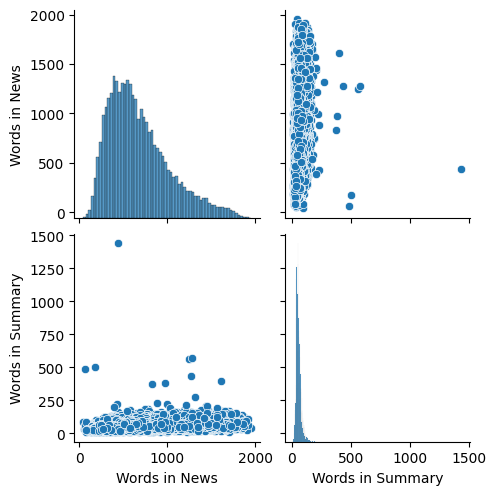

In [14]:
sns.pairplot(data[['Words in News', 'Words in Summary']])

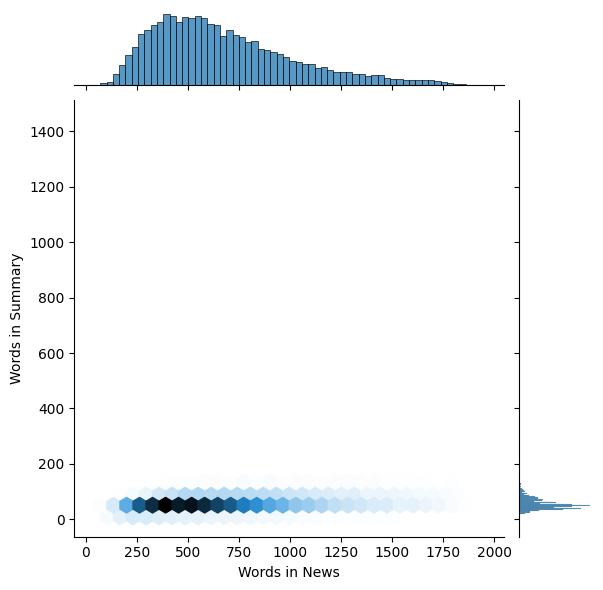

In [15]:
# Hexbin plot to visualize density
sns.jointplot(x='Words in News',
              y='Words in Summary',
              data=data,
              kind='hex',
              gridsize=30)  # Adjust gridsize for granularity

plt.show()

In [16]:
# Function to calculate total unique words and total words with repetition per column
def word_counts_summary(df):
    summary = {}
    for column in df.columns:
        # Get all words in the column
        all_words = [word for phrase in df[column].dropna() for word in phrase.split()]
        # Count unique words
        unique_words_count = len(set(all_words))
        # Count total words with repetition
        total_words_count = len(all_words)
        # Add to summary
        summary[column] = {
            'Total Unique Words': unique_words_count,
            'Total Words (with repetition)': total_words_count
        }
    return summary

# Calculate the word counts summary
word_counts = word_counts_summary(df[['news','summary']])

# Display the result
word_counts


{'news': {'Total Unique Words': 447387,
  'Total Words (with repetition)': 16890669},
 'summary': {'Total Unique Words': 93115,
  'Total Words (with repetition)': 1406199}}

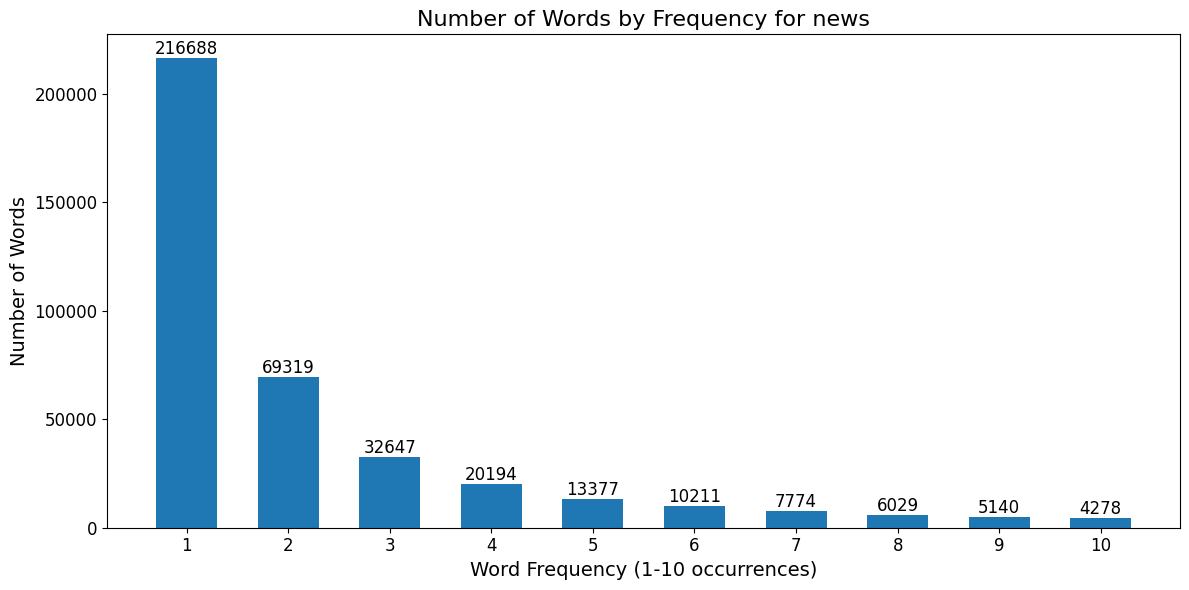

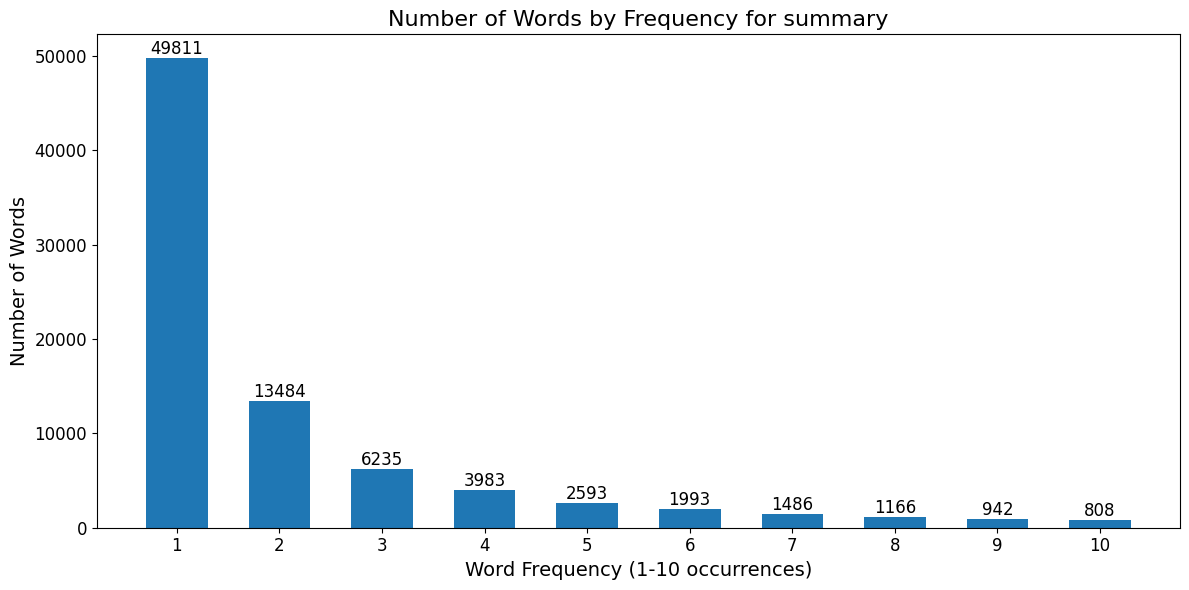

In [17]:
# Function to plot histogram of word frequencies with larger fonts and numbers on top of columns
def plot_histogram_word_counts_with_labels(df):
    for column in df.columns:
        # Count word frequencies
        all_words = [word for phrase in df[column].dropna() for word in phrase.split()]
        word_counts = Counter(all_words)

        # Count the number of words for each frequency (1 to 10)
        frequency_counts = [list(word_counts.values()).count(i) for i in range(1, 11)]

        # Plot histogram
        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(1, 11), frequency_counts, width=0.6)
        plt.title(f"Number of Words by Frequency for {column}", fontsize=16)
        plt.xlabel("Word Frequency (1-10 occurrences)", fontsize=14)
        plt.ylabel("Number of Words", fontsize=14)
        plt.xticks(range(1, 11), fontsize=12)
        plt.yticks(fontsize=12)

        # Add numbers on top of each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add text if the bar height is greater than 0
                plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                         ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

# Plot the histograms
plot_histogram_word_counts_with_labels(df[['news','summary']])


In [18]:
'''
# Generate WordCloud
wc = WordCloud(width=800, height=400).generate(' '.join(df['news'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
'''

"\n# Generate WordCloud\nwc = WordCloud(width=800, height=400).generate(' '.join(df['news'].astype(str)))\nplt.imshow(wc, interpolation='bilinear')\nplt.axis('off')\nplt.show()\n"

In [19]:
'''
# Generate WordCloud
wc = WordCloud(width=800, height=400).generate(' '.join(df['summary'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
'''

"\n# Generate WordCloud\nwc = WordCloud(width=800, height=400).generate(' '.join(df['summary'].astype(str)))\nplt.imshow(wc, interpolation='bilinear')\nplt.axis('off')\nplt.show()\n"

# Model

**Challenges in Text Summarization**
* **Preserving Meaning:**cEnsuring the summary retains the essence of the source text.
* **Handling Ambiguities:** Avoiding misinterpretations, especially in abstractive summaries.
* **Coherence and Readability:**
Generating summaries that are grammatically correct and logically structured.
* **Information Overlap:** Avoiding redundancy and ensuring diverse information coverage.
* **Domain-Specific Texts:** Adapting to specialized jargon or complex domains.
* **Evaluation:** Measuring summary quality objectively is difficult.

### Metrics info:

ROUGE Scores
ROUGE measures the overlap between the predicted and reference summaries in terms of n-grams, longest common subsequence, and sentence-level similarity.

ROUGE-1: Measures unigram overlap (basic word overlap).
ROUGE-2: Measures bigram overlap (two-word sequences).
ROUGE-L: Measures the longest common subsequence overlap (captures fluency and coherence).
Interpretation of ROUGE Scores:
High ROUGE Scores:

ROUGE-1: ≥0.5 (50% unigram overlap is considered good).
ROUGE-2: ≥0.2–0.3 (bigram overlap is harder to achieve).
ROUGE-L: ≥0.2–0.4 (good alignment of subsequences).
Low ROUGE Scores:

ROUGE-1: ≤0.2 (poor word-level match).
ROUGE-2: ≤0.1 (low phrase-level similarity).
ROUGE-L: ≤0.1 (poor structural alignment).

**Note:** ROUGE tends to favor extractive summarization since it measures n-gram overlap. Abstractive summarization often has lower ROUGE scores but can still produce better-quality summaries.
For datasets like CNN/DailyMail or XSum:
ROUGE-1 ≈ 0.35–0.45 is typical for neural models.
ROUGE-2 ≈ 0.15–0.25 is common.




#### Gunning Fog Index
- **What it means**: Estimates the education level required to understand a text. It considers sentence length and the percentage of complex words (those with three or more syllables).
- **How to interpret it**:
  - **6-8**: Easy to understand for general audiences.
  - **10-12**: Suitable for college-level readers.
  - **Above 12**: Complex and difficult for most readers.

#### Spache Readability
- **What it means**: Measures how easy a text is for children or early learners to understand. It evaluates unfamiliar words compared to a predefined list of common words.
- **How to interpret it**:
  - **Below 4**: Easy for young readers.
  - **5-7**: Moderate difficulty.
  - **Above 7**: Challenging for children or early learners.
- **Best use**: Ideal for texts aimed at grades 1-4. Not suitable for adult-level or lengthy content.

#### Automated Readability Index (ARI)
- **What it means**: Estimates the grade level needed to understand the text, based on sentence length and the number of characters per word.
- **How to interpret it**:
  - **1-5**: Suitable for early education (grades 1-5).
  - **6-10**: Appropriate for middle and high school (grades 6-10).
  - **Above 12**: Challenging for average readers (college-level or beyond).

---

### Interpreting Average Readability Metrics
- **Good averages**:
  - Gunning Fog Index: 6–10 (accessible for general readers).
  - Spache Readability: Below 5 (clear for younger readers).
  - ARI: 6–9 (suitable for middle/high school audiences).
- **Bad averages**:
  - Gunning Fog Index: Above 12 (too complex for the public).
  - Spache Readability: Above 7 (too difficult for children).
  - ARI: Above 12 (college-level complexity).


## T5 (Text-to-Text Transfer Transformer)

T5 is a transformer-based model designed by Google to handle a wide range of NLP tasks using a unified framework. It treats every problem—summarization, translation, classification, etc.—as a text-to-text task. Input and output are formatted as text strings, making it flexible and adaptable.


- **Strengths**:
  - Unified architecture for multiple tasks.
  - High performance across NLP benchmarks.
  - Flexible and easy to fine-tune.

In [20]:
# Load a pretrained tokenizer (BERT-based tokenizer for general use)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocess text for T5
def preprocess_text(text):
    """Preprocess text for T5 summarization."""
    # Use the tokenizer's built-in sentence splitting capability
    sentences = tokenizer.tokenize(text)
    # Join back sentences with a space for summarization
    return ' '.join(sentences)

processed_df = df[['news','summary']].copy()
processed_df['news'] = processed_df['news'].apply(preprocess_text)
processed_df['summary'] = processed_df['summary'].apply(preprocess_text)

# Split into training and testing datasets
train_df, test_df = train_test_split(processed_df, test_size=0.2, random_state=42)

# Display the first few rows of the processed DataFrame
processed_df.head()

train_t5_size=len(train_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (970 > 512). Running this sequence through the model will result in indexing errors


In [21]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load T5 tokenizer and model
model_name = "t5-small"  # "t5-small", "t5-base", or "t5-large"        ############
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize datasets
def tokenize_function(batch):
    inputs = ["summarize: " + news for news in batch['news']]
    targets = batch['summary']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    labels = tokenizer(targets, max_length=150, truncation=True, padding="max_length", return_tensors="pt")
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["news", "summary"])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["news", "summary"])

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Replaced 'evaluation_strategy'
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    predict_with_generate=True
)


# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer  # Replaced 'tokenizer' with 'processing_class'
)



# Fine-tune the model
trainer.train()


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/19886 [00:00<?, ? examples/s]

Map:   0%|          | 0/4972 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.126200,1.034423
2,1.105900,1.022227
3,1.089100,1.019108


TrainOutput(global_step=14916, training_loss=1.1352054641214189, metrics={'train_runtime': 1162.9794, 'train_samples_per_second': 51.298, 'train_steps_per_second': 12.826, 'total_flos': 8074221192216576.0, 'train_loss': 1.1352054641214189, 'epoch': 3.0})

In [22]:
def generate_summary(text, min_len=10, max_len=60):
    """Generate a summary for a single article text."""
    # Prepare inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move model & inputs to same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        min_length=min_len,      # <--- Helps avoid empty or very short outputs
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Define summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

subset_t5_size=250
# Select a random subset of 250 news articles
subset_df = test_df.sample(subset_t5_size, random_state=42).copy()

# Use tqdm.notebook to track progress
subset_df['predicted_summary'] = [
    generate_summary(news) for news in tqdm(subset_df['news'], desc="Generating summaries for 250 news articles")
]


# Display 5 random predictions vs ground truth from the subset
sampled = subset_df.sample(5, random_state=42)

for index, row in sampled.iterrows():
    print(f"News: {row['news'][:300]}...\n")
    print(f"Ground Truth Summary: {row['summary']}\n")
    print(f"Predicted Summary: {row['predicted_summary']}\n")
    print("=" * 100)


Device set to use cuda:0


Generating summaries for 250 news articles:   0%|          | 0/250 [00:00<?, ?it/s]

News: game show viewers were left outraged by a buzz ##er ' s failure to ring out on wednesday night ' s family feud , which saw a family miss out on winning a brand - new car . team captains matt mo ##llo ##y and mary ryan were facing off at sudden death when the controversial moment happened . if the ry...

Ground Truth Summary: contestants matt mo ##llo ##y and mary ryan were facing off at sudden death . deny ##er asks the team captains to ' name something you might eat with egg ' mr mo ##llo ##y presses down on his button first then ms ryan pushes down . his buzz ##er fails to ring out while his opponent ' s makes noise and lights up . audience is heard groaning when this happens as deny ##er lets her answer . angered viewers took to social media to vent their frustration ##s about g ##lit ##ch . a family feud statement said ms ryan hit buzz ##er ' with a greater velocity '

Predicted Summary: mary ryan and matt mo ##llo ##y faced off at sudden death on wednesday night. a buzz ##er

In [23]:
# Calculate the number of words in each column
subset_df["Words in news"] = subset_df["news"].astype(str).str.split().apply(len)
subset_df["Words in original"] = subset_df["summary"].astype(str).str.split().apply(len)
subset_df["Words in prediction"] = subset_df["predicted_summary"].astype(str).str.split().apply(len)

# Create a long-format dataframe for visualization
word_counts = subset_df.melt(
    value_vars=["Words in news", "Words in original", "Words in prediction"],
    var_name="Category",
    value_name="Word Count"
)

# Plot histogram with Plotly
fig = px.histogram(
    word_counts,
    x="Word Count",
    color="Category",
    color_discrete_sequence=["#1f77b4", "#ff7f0e", "#2ca02c"],  # Distinct colors
    labels={"Category": "Text Type", "Word Count": "Number of Words"},
    marginal="box",  # Add box plots to the histogram
    barmode="group",  # Group bars by category
    height=540,
    width=840,
    title="Word Distribution - News, Original Summary, and Predicted Summary",
)

# Update layout for better aesthetics
fig.update_layout(
    font_color="black",
    title_font_size=18,
    plot_bgcolor="white",
    paper_bgcolor="white",
    bargap=0.2,
    bargroupgap=0.1,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.02,
        x=1,
    ),
    yaxis_title="Count",
    xaxis_title="Number of Words",
)

# Display the plot
fig.show()


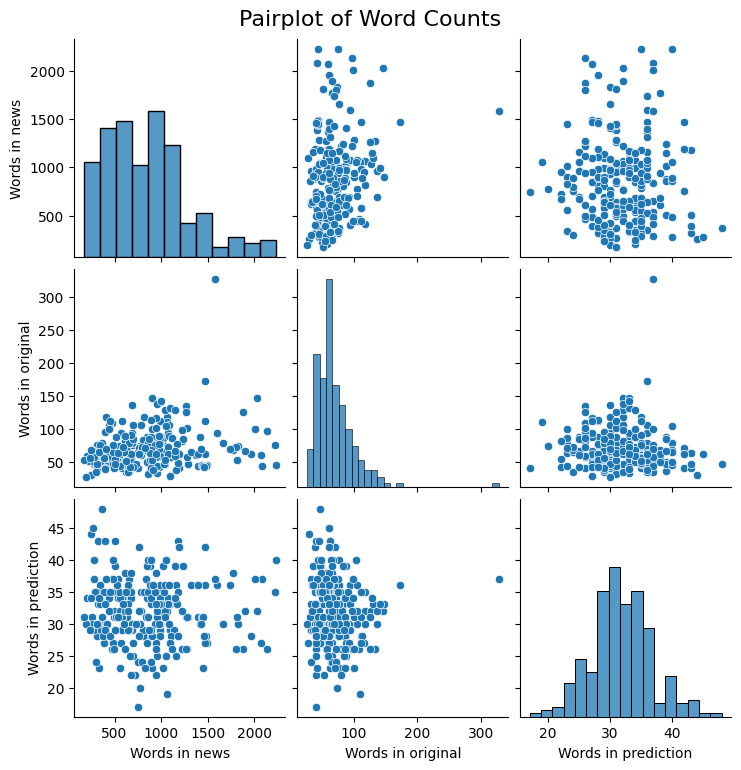

In [24]:
# Pair plot with Seaborn
sns.pairplot(subset_df[["Words in news", "Words in original", "Words in prediction"]])
plt.suptitle("Pairplot of Word Counts", y=1.02, fontsize=16)
plt.show()

In [25]:
# Use the Hugging Face tokenizer for tokenization
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
meteor_scores = []

# Use subset_df for evaluation
for _, row in subset_df.iterrows():
    # Tokenize the summaries for METEOR using the Hugging Face tokenizer
    tokenized_summary = tokenizer.tokenize(row['summary'])
    tokenized_predicted = tokenizer.tokenize(row['predicted_summary'])

    # Compute ROUGE scores
    rouge_score = rouge.score(row['summary'], row['predicted_summary'])
    rouge_scores.append(rouge_score)

    # Compute METEOR scores
    meteor = meteor_score([tokenized_summary], tokenized_predicted)
    meteor_scores.append(meteor)

# Calculate average scores
avg_rouge1_t5 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2_t5 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL_t5 = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_meteor_t5 = sum(meteor_scores) / len(meteor_scores)

print(f"Average ROUGE-1 Score: {avg_rouge1_t5:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2_t5:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL_t5:.4f}")
print(f"Average METEOR Score: {avg_meteor_t5:.4f}")

Average ROUGE-1 Score: 0.3603
Average ROUGE-2 Score: 0.1858
Average ROUGE-L Score: 0.2674
Average METEOR Score: 0.2700


In [26]:
# Compute readability metrics for the predicted summaries
def calculate_readability_metrics(text):
    """Calculate readability metrics for a given text."""
    try:
        spache_readability = textstat.spache_readability(text)
    except Exception:
        spache_readability = None  # Set to None if Spache is not applicable

    return {
        "Gunning Fog Index": textstat.gunning_fog(text),
        "Spache Readability": spache_readability,
        "Automated Readability Index": textstat.automated_readability_index(text),
    }

# Apply readability metrics to the predicted summaries in the test set
subset_df['readability_metrics'] = subset_df['predicted_summary'].apply(calculate_readability_metrics)

# Display a sample of results
print(subset_df[['predicted_summary', 'readability_metrics']].head())

'''
# Average readability metrics for the test set
readability_averages = {
    "Average Gunning Fog Index": subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean(),
    "Average Spache Readability": subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean(),
    "Average Automated Readability Index": subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean(),
}

print("\nAverage Readability Metrics for the Test Set:")
for metric, value in readability_averages.items():
    print(f"{metric}: {value:.2f}")
'''

# Calculate Average Readability Metrics
readability_averages = {
    "avg_gunning_fog_t5": subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean(),
    "avg_spache_t5": subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean(),
    "avg_automated_readability_t5": subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean(),
}

# Calculate Average Readability Metrics
avg_gunning_fog_t5 = subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean()
avg_spache_t5 = subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean()
avg_automated_readability_t5 = subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean()

# Print and Save Metrics
print("\nAverage Readability Metrics for the Test Set:")
for metric, value in readability_averages.items():
    print(f"{metric}: {value:.2f}")

                                       predicted_summary  \
13674  a man opposed to joint south korean - u. s. mi...   
4569   s ##np leader used bbc tv debate to offer to'l...   
604    ii ##net limited, intern ##ode, am ##net broad...   
2208   a 2012 paperback book of songs used by the u. ...   
17634  season 20 kicks off its 10 - year anniversary ...   

                                     readability_metrics  
13674  {'Gunning Fog Index': 8.92, 'Spache Readabilit...  
4569   {'Gunning Fog Index': 11.94, 'Spache Readabili...  
604    {'Gunning Fog Index': 11.32, 'Spache Readabili...  
2208   {'Gunning Fog Index': 8.46, 'Spache Readabilit...  
17634  {'Gunning Fog Index': 8.9, 'Spache Readability...  

Average Readability Metrics for the Test Set:
avg_gunning_fog_t5: 8.78
avg_spache_t5: 4.59
avg_automated_readability_t5: 8.33


In [27]:
# Compute BERTScore
P, R, F1 = score(
    subset_df['predicted_summary'].tolist(),
    subset_df['summary'].tolist(),
    lang="en"  # Set language to English
)

# Average BERTScore
average_bertscore_t5 = F1.mean().item()
print(f"Average BERTScore (F1): {average_bertscore_t5:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore (F1): 0.8550


In [28]:
subset_df['flesch_kincaid_grade'] = subset_df['predicted_summary'].apply(textstat.flesch_kincaid_grade)
average_fk_grade_t5 = subset_df['flesch_kincaid_grade'].mean()
print(f"Average Flesch-Kincaid Grade Level: {average_fk_grade_t5:.2f}")


Average Flesch-Kincaid Grade Level: 6.37


## PEGASUS

Pegasus is a transformer-based model designed by Google for abstractive summarization tasks. It introduces a unique pretraining objective where important sentences are masked (gap-sentences) and the model learns to generate them, mimicking real-world summarization.

- **Strengths**:
  - State-of-the-art performance on abstractive summarization benchmarks.
  - Excels at generating fluent and coherent summaries.


In [29]:
# --------------------------------------------------------------------------
# 1. Load a pretrained PEGASUS tokenizer
# --------------------------------------------------------------------------
model_name = "google/pegasus-xsum"
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# --------------------------------------------------------------------------
# 2. (Optional) Preprocessing: For PEGASUS, a simple text strip can suffice.
# --------------------------------------------------------------------------
def preprocess_text(text):
    """Preprocess text for PEGASUS summarization."""
    # Minimal: Strip whitespace. Expand this function as needed.
    return text.strip()

processed_df = df[['news', 'summary']].copy()
processed_df['news'] = processed_df['news'].apply(preprocess_text)
processed_df['summary'] = processed_df['summary'].apply(preprocess_text)
processed_df=processed_df[:2500]



tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

In [30]:
# --------------------------------------------------------------------------
# 3. Split into training and testing datasets
# --------------------------------------------------------------------------
train_df, test_df = train_test_split(processed_df, test_size=0.2, random_state=42)

train_pegasus_size=len(train_df)
# --------------------------------------------------------------------------
# 4. Convert to Hugging Face Dataset
# --------------------------------------------------------------------------
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [31]:
# --------------------------------------------------------------------------
# 5. Tokenize the datasets for PEGASUS
# --------------------------------------------------------------------------
def tokenize_function(batch):
    # PEGASUS uses the same input for "input_ids" and separate "labels"
    # for the summaries. We truncate for a maximum length to fit the model.
    model_inputs = tokenizer(batch['news'], max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(batch['summary'], max_length=50, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [32]:
# --------------------------------------------------------------------------
# 6. Load the PEGASUS model
# --------------------------------------------------------------------------
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# --------------------------------------------------------------------------
# 7. Define training arguments
# --------------------------------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    predict_with_generate=True,
)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [33]:
'''# 1. Model/Tokenizer Setup
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)


def preprocess_function(batch):
    model_inputs = tokenizer(
        batch["news"],
        max_length=128,
        truncation=True,
        padding="max_length",
    )
    labels = tokenizer(
        batch["summary"],
        max_length=50,
        truncation=True,
        padding="max_length",
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)'''


model = PegasusForConditionalGeneration.from_pretrained(model_name)

# 3. Custom Callback to Collect Metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.metrics.append(logs)

metrics_callback = MetricsCallback()

# 4. Define TrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,          # Train for 3 epochs
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    predict_with_generate=True,
    report_to="none",            # Disable external logging (e.g., WandB)
)

# 5. Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[metrics_callback],
)

# 6. Fine-tune the model & measure runtime
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time / 60:.2f} minutes)")



Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.079400,2.000479
2,1.487800,1.925212
3,1.631100,1.851325


Training completed in 789.66 seconds (13.16 minutes)


In [35]:
# --------------------------------------------------------------------------
# 9. Generate summaries
# --------------------------------------------------------------------------
def generate_summary(text, min_len=10, max_len=60):
    """Generate a summary for a single article text."""
    # Prepare inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move model & inputs to same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        min_length=min_len,      # <--- Helps avoid empty or very short outputs
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Number of rows you want to sample from test_df
subset_size_pegasus = min(30, len(test_df))

# 1. Sample 100 rows from test_df
subset_df = test_df[['news', 'summary']].sample(n=subset_size_pegasus, random_state=42).copy()

# 2. Generate predicted summaries for each row's 'news' text
subset_df['predicted_summary'] = subset_df['news'].apply(generate_summary)

# Generate random indices based on subset_df's size
random_indices = random.sample(range(len(subset_df)), min(5, len(subset_df)))

print("\n=== 5 Random Summaries ===")
for i in random_indices:
    article_text = subset_df.iloc[i]["news"]
    predicted_summary = subset_df.iloc[i]["predicted_summary"]
    print(f"\nArticle index: {i}")
    print("Original text:    ", article_text[:300], "...")  # Limit display length for readability
    print("Predicted summary:", predicted_summary)
    print("=" * 100)


=== 5 Random Summaries ===

Article index: 20
Original text:     Former NFL cornerback Will Allen and his business partner are facing civil fraud charges from federal regulators over allegations the pair ran a multi-million dollar Ponzi scheme. They're accused of reaping more than $31 million in a Ponzi scheme that promised high returns to investors from funding  ...
Predicted summary: Will Allen, 36, was a cornerback in the NFL from 2001 to 2012, playing for the New York Giants and Miami Dolphins

Article index: 3
Original text:     Pope Francis has accepted the resignation  of an American bishop who pleaded guilty to failing to report a priest who was a suspected child abuser. Bishop Robert Finn, 62, offered his resignation under the code of canon law that allows bishops to resign early for illness or some 'grave' reason that  ...
Predicted summary: Bishop Robert Finn, 62, offered his resignation under the code of canon law that allows bishops to resign early for illness or some 'gr

In [36]:
'''

# --------------------------------------------------------------------------
# B. Calculate ROUGE and METEOR for 50 test samples (or all, if < 50)
# --------------------------------------------------------------------------
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

max_samples = min(50, len(subset_df))
references = []
predictions = []

print("\n=== Evaluating ROUGE & METEOR on up to 50 test samples ===")
for i in range(max_samples):
    # Original text & ground-truth
    article_text = subset_df.iloc[i]["news"]
    reference_summary = subset_df.iloc[i]["summary"]

    # Predicted summary
    predicted_summary = generate_summary(article_text)

    references.append(reference_summary)
    predictions.append(predicted_summary)

# Compute ROUGE scores
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("ROUGE Scores:", rouge_scores)

# Compute METEOR
meteor_score = meteor.compute(predictions=predictions, references=references)
print("METEOR Score:", meteor_score)

# Save metrics with "_bart" suffix
scores_bart = {
    "avg_rouge1_pegasus": rouge_scores["rouge1"],
    "avg_rouge2_pegasus": rouge_scores["rouge2"],
    "avg_rougeL_pegasus": rouge_scores["rougeL"],
    "avg_meteor_pegasus": meteor_score_bart["meteor"]
}
'''

'\n\n# --------------------------------------------------------------------------\n# B. Calculate ROUGE and METEOR for 50 test samples (or all, if < 50)\n# --------------------------------------------------------------------------\nrouge = evaluate.load("rouge")\nmeteor = evaluate.load("meteor")\n\nmax_samples = min(50, len(subset_df))\nreferences = []\npredictions = []\n\nprint("\n=== Evaluating ROUGE & METEOR on up to 50 test samples ===")\nfor i in range(max_samples):\n    # Original text & ground-truth\n    article_text = subset_df.iloc[i]["news"]\n    reference_summary = subset_df.iloc[i]["summary"]\n\n    # Predicted summary\n    predicted_summary = generate_summary(article_text)\n\n    references.append(reference_summary)\n    predictions.append(predicted_summary)\n\n# Compute ROUGE scores\nrouge_scores = rouge.compute(predictions=predictions, references=references)\nprint("ROUGE Scores:", rouge_scores)\n\n# Compute METEOR\nmeteor_score = meteor.compute(predictions=predictions, 

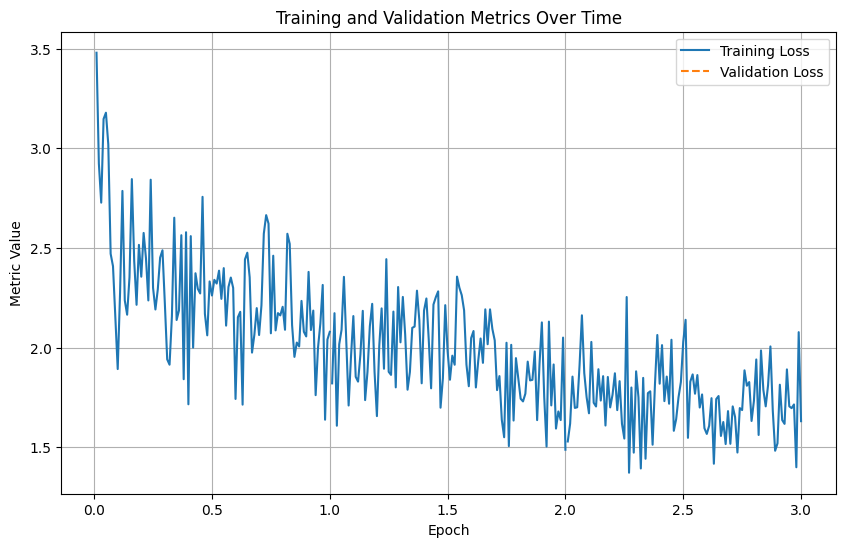

In [37]:
metrics_df = pd.DataFrame(metrics_callback.metrics)

# Use 'epoch' as the x-axis if 'step' is missing
x_key = 'step' if 'step' in metrics_df.columns else 'epoch'

plt.figure(figsize=(10, 6))
plt.plot(metrics_df[x_key], metrics_df["loss"], label="Training Loss")
if "eval_loss" in metrics_df.columns:
    plt.plot(metrics_df[x_key], metrics_df["eval_loss"], label="Validation Loss", linestyle="--")
if "accuracy" in metrics_df.columns:
    plt.plot(metrics_df[x_key], metrics_df["accuracy"], label="Accuracy", linestyle=":")
plt.xlabel(x_key.capitalize())
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics Over Time")
plt.legend()
plt.grid()
plt.show()


In [38]:
# Calculate the number of words in each column
subset_df["Words in news"] = subset_df["news"].astype(str).str.split().apply(len)
subset_df["Words in original"] = subset_df["summary"].astype(str).str.split().apply(len)
subset_df["Words in prediction"] = subset_df["predicted_summary"].astype(str).str.split().apply(len)

# Create a long-format dataframe for visualization
word_counts = subset_df.melt(
    value_vars=["Words in news", "Words in original", "Words in prediction"],
    var_name="Category",
    value_name="Word Count"
)

# Plot histogram with Plotly
fig = px.histogram(
    word_counts,
    x="Word Count",
    color="Category",
    color_discrete_sequence=["#1f77b4", "#ff7f0e", "#2ca02c"],  # Distinct colors
    labels={"Category": "Text Type", "Word Count": "Number of Words"},
    marginal="box",  # Add box plots to the histogram
    barmode="group",  # Group bars by category
    height=540,
    width=840,
    title="Word Distribution - News, Original Summary, and Predicted Summary",
)

# Update layout for better aesthetics
fig.update_layout(
    font_color="black",
    title_font_size=18,
    plot_bgcolor="white",
    paper_bgcolor="white",
    bargap=0.2,
    bargroupgap=0.1,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.02,
        x=1,
    ),
    yaxis_title="Count",
    xaxis_title="Number of Words",
)

# Display the plot
fig.show()


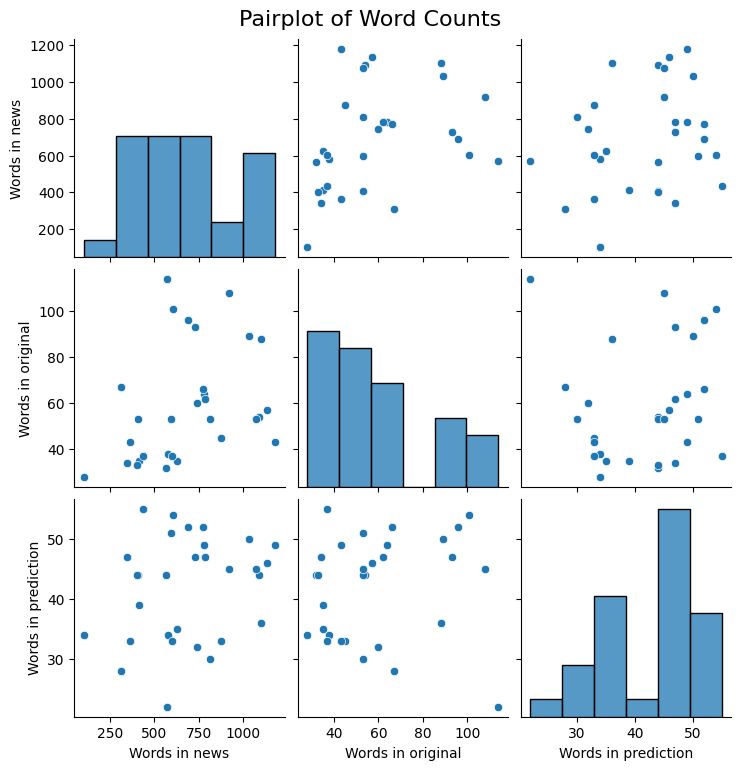

In [39]:
# Pair plot with Seaborn
sns.pairplot(subset_df[["Words in news", "Words in original", "Words in prediction"]])
plt.suptitle("Pairplot of Word Counts", y=1.02, fontsize=16)
plt.show()

In [40]:
# Use the Hugging Face tokenizer for tokenization
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
meteor_scores = []

# Use subset_df for evaluation
for _, row in subset_df.iterrows():
    # Tokenize the summaries for METEOR using the Hugging Face tokenizer
    tokenized_summary = tokenizer.tokenize(row['summary'])
    tokenized_predicted = tokenizer.tokenize(row['predicted_summary'])

    # Compute ROUGE scores
    rouge_score = rouge.score(row['summary'], row['predicted_summary'])
    rouge_scores.append(rouge_score)

    # Compute METEOR scores
    meteor = meteor_score([tokenized_summary], tokenized_predicted)
    meteor_scores.append(meteor)

# Calculate average scores
avg_rouge1_pegasus = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2_pegasus = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL_pegasus = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_meteor_pegasus = sum(meteor_scores) / len(meteor_scores)

print(f"Average ROUGE-1 Score: {avg_rouge1_pegasus:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2_pegasus:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL_pegasus:.4f}")
print(f"Average METEOR Score: {avg_meteor_pegasus:.4f}")

Average ROUGE-1 Score: 0.3630
Average ROUGE-2 Score: 0.1627
Average ROUGE-L Score: 0.2690
Average METEOR Score: 0.3110


In [41]:
# Compute readability metrics for the predicted summaries
def calculate_readability_metrics(text):
    """Calculate readability metrics for a given text."""
    try:
        spache_readability = textstat.spache_readability(text)
    except Exception:
        spache_readability = None  # Set to None if Spache is not applicable

    return {
        "Gunning Fog Index": textstat.gunning_fog(text),
        "Spache Readability": spache_readability,
        "Automated Readability Index": textstat.automated_readability_index(text),
    }

# Apply readability metrics to the predicted summaries in the test set
subset_df['readability_metrics'] = subset_df['predicted_summary'].apply(calculate_readability_metrics)

# Display a sample of results
print(subset_df[['predicted_summary', 'readability_metrics']].head())

# Average readability metrics for the test set
readability_averages = {
    "avg_gunning_fog_pegasus": subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean(),
    "avg_spache_pegasus": subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean(),
    "avg_automated_readability_pegasus": subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean(),
}

# Calculate Average Readability Metrics
avg_gunning_fog_pegasus = subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean()
avg_spache_pegasus = subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean()
avg_automated_readability_pegasus = subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean()


print("\nAverage Readability Metrics for the Test Set:")
for metric, value in readability_averages.items():
    print(f"{metric}: {value:.2f}")


                                      predicted_summary  \
1476  Neanderthals may have succumbed to infectious ...   
1084  Stephanie March filed for divorce from Bobby F...   
163   Bon Jovi guitarist Richie Sambora is being inv...   
1968  Bishop Robert Finn, 62, offered his resignatio...   
544   Nearly half of the British public believe the ...   

                                    readability_metrics  
1476  {'Gunning Fog Index': 16.02, 'Spache Readabili...  
1084  {'Gunning Fog Index': 7.49, 'Spache Readabilit...  
163   {'Gunning Fog Index': 13.44, 'Spache Readabili...  
1968  {'Gunning Fog Index': 11.27, 'Spache Readabili...  
544   {'Gunning Fog Index': 8.15, 'Spache Readabilit...  

Average Readability Metrics for the Test Set:
avg_gunning_fog_pegasus: 10.87
avg_spache_pegasus: 5.37
avg_automated_readability_pegasus: 10.83


In [42]:
# Compute BERTScore
P, R, F1 = score(
    subset_df['predicted_summary'].tolist(),
    subset_df['summary'].tolist(),
    lang="en"  # Set language to English
)

# Average BERTScore
average_bertscore_pegasus = F1.mean().item()
print(f"Average BERTScore (F1): {average_bertscore_pegasus:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore (F1): 0.8733


In [43]:
subset_df['flesch_kincaid_grade'] = subset_df['predicted_summary'].apply(textstat.flesch_kincaid_grade)
average_fk_grade_pegasus = subset_df['flesch_kincaid_grade'].mean()
print(f"Average Flesch-Kincaid Grade Level: {average_fk_grade_pegasus:.2f}")


Average Flesch-Kincaid Grade Level: 8.55


## BART (Bidirectional and Auto-Regressive Transformers)

BART is a transformer model from Facebook designed for text generation and comprehension tasks. It combines bidirectional (like BERT) and autoregressive (like GPT) architectures, making it effective for both understanding and generating text.


- **Strengths**:
  - Versatile and robust for a wide range of NLP tasks.
  - Strong performance on text generation and denoising tasks.


In [45]:
# --------------------------------------------------------------------------
# 1. Load a pretrained BART tokenizer (e.g., 'facebook/bart-large-cnn')
# --------------------------------------------------------------------------
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# --------------------------------------------------------------------------
# 2. Preprocessing for BART - simple text strip (customize as needed)
# --------------------------------------------------------------------------
def preprocess_text(text):
    """Preprocess text for BART summarization."""
    return text.strip()

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [46]:
# (Optional) limit the DataFrame size
processed_df = df[:2500]

# Apply minimal cleaning
processed_df["news"] = processed_df["news"].apply(preprocess_text)
processed_df["summary"] = processed_df["summary"].apply(preprocess_text)

# --------------------------------------------------------------------------
# 3. Split into training and testing datasets
# --------------------------------------------------------------------------
train_df, test_df = train_test_split(processed_df, test_size=0.2, random_state=42)

train_size_bart= len(train_df)
# --------------------------------------------------------------------------
# 4. Convert to Hugging Face Dataset
# --------------------------------------------------------------------------
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [47]:
# --------------------------------------------------------------------------
# 5. Tokenize the datasets for BART
# --------------------------------------------------------------------------
def tokenize_function(batch):
    """Truncate/pad the 'news' text and 'summary' for BART."""
    model_inputs = tokenizer(
        batch['news'],
        max_length=512,  # BART can handle up to 1024, but 512 is common
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        batch['summary'],
        max_length=50,
        truncation=True,
        padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["news", "summary"])
test_dataset  = test_dataset.map(tokenize_function,  batched=True, remove_columns=["news", "summary"])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [48]:
# --------------------------------------------------------------------------
# 6. Load the BART model
# --------------------------------------------------------------------------
model = BartForConditionalGeneration.from_pretrained(model_name)

# --------------------------------------------------------------------------
# 7. Custom Callback to Collect Metrics (loss, eval_loss, etc.)
# --------------------------------------------------------------------------
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.metrics.append(logs)

metrics_callback = MetricsCallback()

# --------------------------------------------------------------------------
# 8. Define Seq2SeqTrainingArguments
# --------------------------------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",     # Evaluate after each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    predict_with_generate=True,
    report_to="none",               # Disable external logging integrations
)

# --------------------------------------------------------------------------
# 9. Initialize the Trainer
# --------------------------------------------------------------------------
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[metrics_callback],
)

# --------------------------------------------------------------------------
# 10. Fine-tune the model & measure runtime
# --------------------------------------------------------------------------
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time / 60:.2f} minutes)")


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,1.791500,1.674607
2,0.782700,1.700494
3,0.362200,2.006169



Training completed in 568.36 seconds (9.47 minutes)


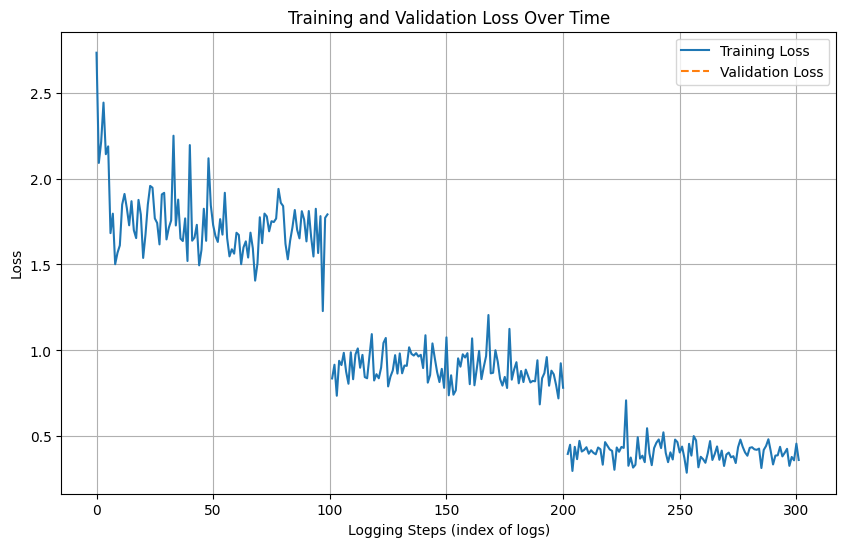

In [49]:
# --------------------------------------------------------------------------
# 11. Plot the evolution of loss over the training steps
#     (You can also plot 'eval_loss' if it is logged)
# --------------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics_callback.metrics)

plt.figure(figsize=(10, 6))
# If "loss" is in logs, plot training loss
if "loss" in metrics_df.columns:
    plt.plot(metrics_df.index, metrics_df["loss"], label="Training Loss")

# If "eval_loss" is in logs, plot validation loss
if "eval_loss" in metrics_df.columns:
    plt.plot(metrics_df.index, metrics_df["eval_loss"], label="Validation Loss", linestyle="--")

plt.xlabel("Logging Steps (index of logs)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# --------------------------------------------------------------------------
# 12. Generate summaries on random test samples
# --------------------------------------------------------------------------
def generate_summary(text, min_len=10, max_len=60):
    """Generate a summary for a single article text."""
    # Prepare inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move model & inputs to same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        min_length=min_len,  # helps avoid very short outputs
        max_length=max_len,
        num_beams=4,
        early_stopping=True,
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("\n=== 5 Random Summaries from test_df ===")
random_indices = random.sample(range(len(test_df)), min(5, len(test_df)))
for i in random_indices:
    # If original text is in your test_df's "news" column
    # we removed those columns when creating test_dataset, so we use test_df directly
    article_text = test_df.iloc[i]["news"]
    predicted_summary = generate_summary(article_text)
    print(f"\n--- Article index: {i} ---")
    print("Original text:    ", article_text)
    print("Predicted summary:", predicted_summary)


=== 5 Random Summaries from test_df ===

--- Article index: 327 ---
Original text:     Scotland will discover on May 21 if September's Euro 2016 qualifier with Georgia will be played behind closed doors. UEFA has announced it has opened disciplinary proceedings against the Georgian Football Federation (GFF) after fans twice invaded the field of play during Sunday's 2-0 defeat by Germany in Tbilisi. European football's governing body is also set to look at charges that allege home fans were guilty of setting off fireworks while a string of safety breaches, including blocked stairs, locked gates and a lack of body searches by staff at the Boris Paichadze Stadium, will also be investigated. A fan invades the pitch during Georgia's 2-0 defeat by Germany on Sunday in Tbilisi . Play was halted twice at the Boris Paichadze Stadium due to Georgia fans arriving onto the field . UEFA's Control, Ethics and Disciplinary Body will decide the case on May 21. The GFF has already vowed to tighten up 

In [51]:
# --------------------------------------------------------------------------
# 13. Create a DataFrame with original columns + predicted_summary
#     Sample 100 (or 30) rows from test_df, for example
# --------------------------------------------------------------------------
subset_size_bart=30
num_samples = min(subset_size_bart, len(test_df))
subset_df = test_df[['news', 'summary']].sample(n=num_samples, random_state=42).copy()
subset_df['predicted_summary'] = subset_df['news'].apply(generate_summary)

print("\n--- Subset DataFrame with Predicted Summaries ---")
print(subset_df.head())


--- Subset DataFrame with Predicted Summaries ---
                                                   news  \
1476  Modern humans have been blamed for killing off...   
1084  Bobby Flay is said to be offering his soon-to-...   
163   Rocker Richie Sambora is being investigated by...   
1968  Pope Francis has accepted the resignation  of ...   
544   Nearly half of the British public believe the ...   

                                                summary  \
1476  Anthropologists claim that Neanderthals suffer...   
1084  Bobby and Stephanie separated three weeks ago ...   
163   Richie Sambora is about to be quizzed by polic...   
1968  Bishop Robert Finn failed to notify police abo...   
544   Prince Charles and Camilla  will celebrate the...   

                                      predicted_summary  
1476  Scientists say modern humans carried diseases ...  
1084  According to TMZ, the prenup between the Food ...  
163   Richie Sambora, 55, allegedly told former busi...  
1968  B

In [52]:
# Calculate the number of words in each column
subset_df["Words in news"] = subset_df["news"].astype(str).str.split().apply(len)
subset_df["Words in original"] = subset_df["summary"].astype(str).str.split().apply(len)
subset_df["Words in prediction"] = subset_df["predicted_summary"].astype(str).str.split().apply(len)

# Create a long-format dataframe for visualization
word_counts = subset_df.melt(
    value_vars=["Words in news", "Words in original", "Words in prediction"],
    var_name="Category",
    value_name="Word Count"
)

# Plot histogram with Plotly
fig = px.histogram(
    word_counts,
    x="Word Count",
    color="Category",
    color_discrete_sequence=["#1f77b4", "#ff7f0e", "#2ca02c"],  # Distinct colors
    labels={"Category": "Text Type", "Word Count": "Number of Words"},
    marginal="box",  # Add box plots to the histogram
    barmode="group",  # Group bars by category
    height=540,
    width=840,
    title="Word Distribution - News, Original Summary, and Predicted Summary",
)

# Update layout for better aesthetics
fig.update_layout(
    font_color="black",
    title_font_size=18,
    plot_bgcolor="white",
    paper_bgcolor="white",
    bargap=0.2,
    bargroupgap=0.1,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.02,
        x=1,
    ),
    yaxis_title="Count",
    xaxis_title="Number of Words",
)

# Display the plot
fig.show()


In [61]:
# Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Initialize predictions and references
max_samples = min(50, len(test_df))
references = []
predictions = []

print("\n=== Evaluating ROUGE & METEOR on up to 50 test samples ===")
for i in range(max_samples):
    # Original text & ground-truth
    article_text = test_df.iloc[i]["news"]
    reference_summary = test_df.iloc[i]["summary"]

    # Predicted summary
    predicted_summary = generate_summary(article_text)  # Ensure `generate_summary` is implemented

    references.append(reference_summary)
    predictions.append(predicted_summary)

# Compute ROUGE
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("\nROUGE Scores:")
for metric, value in rouge_scores.items():
    print(f"{metric}: {value:.4f}")  # Directly print the scalar value

# Compute METEOR
meteor_score_bart = meteor.compute(predictions=predictions, references=references)
print("\nMETEOR Score:", meteor_score_bart["meteor"])

# Save metrics with "_bart" suffix
avg_rouge1_bart = rouge_scores["rouge1"]
avg_rouge2_bart = rouge_scores["rouge2"]
avg_rougeL_bart = rouge_scores["rougeL"]
avg_meteor_bart = meteor_score_bart["meteor"]

scores_bart = {
    "avg_rouge1_bart": avg_rouge1_bart,
    "avg_rouge2_bart": avg_rouge2_bart,
    "avg_rougeL_bart": avg_rougeL_bart,
    "avg_meteor_bart": avg_meteor_bart
}

# Print final average scores
print("\nFinal Average Scores:")
for key, value in scores_bart.items():
    print(f"{key}: {value:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



=== Evaluating ROUGE & METEOR on up to 50 test samples ===

ROUGE Scores:
rouge1: 0.3981
rouge2: 0.1945
rougeL: 0.2851
rougeLsum: 0.3721

METEOR Score: 0.2939130936030332

Final Average Scores:
avg_rouge1_bart: 0.3981
avg_rouge2_bart: 0.1945
avg_rougeL_bart: 0.2851
avg_meteor_bart: 0.2939


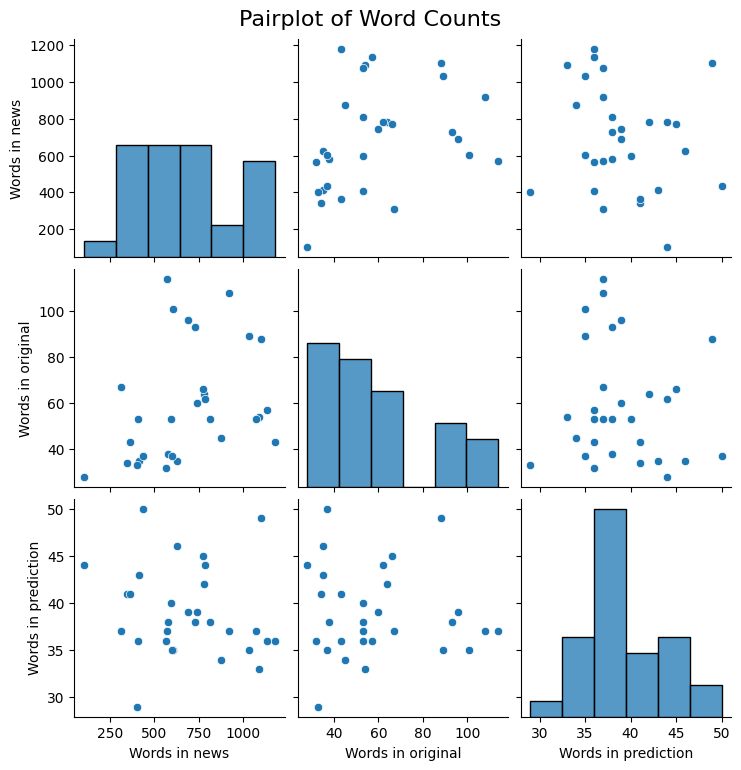

In [54]:
# Pair plot with Seaborn
sns.pairplot(subset_df[["Words in news", "Words in original", "Words in prediction"]])
plt.suptitle("Pairplot of Word Counts", y=1.02, fontsize=16)
plt.show()

In [55]:
# Compute readability metrics for the predicted summaries
def calculate_readability_metrics(text):
    """Calculate readability metrics for a given text."""
    try:
        spache_readability = textstat.spache_readability(text)
    except Exception:
        spache_readability = None  # Set to None if Spache is not applicable

    return {
        "Gunning Fog Index": textstat.gunning_fog(text),
        "Spache Readability": spache_readability,
        "Automated Readability Index": textstat.automated_readability_index(text),
    }

# Apply readability metrics to the predicted summaries in the test set
subset_df['readability_metrics'] = subset_df['predicted_summary'].apply(calculate_readability_metrics)

# Display a sample of results
print(subset_df[['predicted_summary', 'readability_metrics']].head())

# Calculate Average Readability Metrics
readability_averages = {
    "avg_gunning_fog_bart": subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean(),
    "avg_spache_bart": subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean(),
    "avg_automated_readability_bart": subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean(),
}

# Calculate Average Readability Metrics
avg_gunning_fog_bart = subset_df['readability_metrics'].apply(lambda x: x['Gunning Fog Index']).mean()
avg_spache_bart = subset_df['readability_metrics'].apply(lambda x: x['Spache Readability']).dropna().mean()
avg_automated_readability_bart = subset_df['readability_metrics'].apply(lambda x: x['Automated Readability Index']).mean()

# Print and Save Metrics
print("\nAverage Readability Metrics for the Test Set:")
for metric, value in readability_averages.items():
    print(f"{metric}: {value:.2f}")


                                      predicted_summary  \
1476  Scientists say modern humans carried diseases ...   
1084  According to TMZ, the prenup between the Food ...   
163   Richie Sambora, 55, allegedly told former busi...   
1968  Bishop Robert Finn, 62, offered his resignatio...   
544   50 per cent of Britons believe Camilla, Duches...   

                                    readability_metrics  
1476  {'Gunning Fog Index': 9.28, 'Spache Readabilit...  
1084  {'Gunning Fog Index': 10.76, 'Spache Readabili...  
163   {'Gunning Fog Index': 18.36, 'Spache Readabili...  
1968  {'Gunning Fog Index': 8.32, 'Spache Readabilit...  
544   {'Gunning Fog Index': 5.08, 'Spache Readabilit...  

Average Readability Metrics for the Test Set:
avg_gunning_fog_bart: 9.60
avg_spache_bart: 4.95
avg_automated_readability_bart: 9.70


In [56]:
# Compute BERTScore
P, R, F1 = score(
    subset_df['predicted_summary'].tolist(),
    subset_df['summary'].tolist(),
    lang="en"  # Set language to English
)

# Average BERTScore
average_bertscore_bart = F1.mean().item()
print(f"Average BERTScore (F1): {average_bertscore_bart:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore (F1): 0.8790


In [57]:
subset_df['flesch_kincaid_grade'] = subset_df['predicted_summary'].apply(textstat.flesch_kincaid_grade)
average_fk_grade_bart = subset_df['flesch_kincaid_grade'].mean()
print(f"Average Flesch-Kincaid Grade Level: {average_fk_grade_bart:.2f}")


Average Flesch-Kincaid Grade Level: 7.45


# Final Comparison

In [82]:
# Create a DataFrame
data = {
    "T5": [
        train_t5_size, subset_t5_size, "",  # Train size, subset size, empty row
        avg_rouge1_t5, avg_rouge2_t5, avg_rougeL_t5, avg_meteor_t5,
        avg_gunning_fog_t5, avg_spache_t5, avg_automated_readability_t5,
        average_bertscore_t5, average_fk_grade_t5
    ],
    "Pegasus": [
        train_pegasus_size, subset_size_pegasus, "",  # Train size, subset size, empty row
        avg_rouge1_pegasus, avg_rouge2_pegasus, avg_rougeL_pegasus, avg_meteor_pegasus,
        avg_gunning_fog_pegasus, avg_spache_pegasus, avg_automated_readability_pegasus,
        average_bertscore_pegasus, average_fk_grade_pegasus
    ],
    "BART": [
        train_size_bart, subset_size_bart, "",  # Train size, subset size, empty row
        avg_rouge1_bart, avg_rouge2_bart, avg_rougeL_bart, avg_meteor_bart,
        avg_gunning_fog_bart, avg_spache_bart, avg_automated_readability_bart,
        average_bertscore_bart, average_fk_grade_bart
    ],
}

# Row labels
index = [
    "Train Size", "Subset Size", "",  # Empty row
    "ROUGE-1", "ROUGE-2", "ROUGE-L", "METEOR",
    "Gunning Fog", "Spache", "Automated Readability",
    "BERTScore", "Flesch-Kincaid Grade"
]

# Create the DataFrame
df = pd.DataFrame(data, index=index)

df = df.applymap(lambda x: round(float(x), 3) if isinstance(x, (int, float)) else x)

In [83]:
# Display the DataFrame
print(df)

                            T5 Pegasus    BART
Train Size             19886.0  2000.0  2000.0
Subset Size              250.0    30.0    30.0
                                              
ROUGE-1                   0.36   0.363   0.398
ROUGE-2                  0.186   0.163   0.195
ROUGE-L                  0.267   0.269   0.285
METEOR                    0.27   0.311   0.294
Gunning Fog              8.777  10.871   9.597
Spache                   4.591   5.366   4.951
Automated Readability    8.332  10.827   9.703
BERTScore                0.855   0.873   0.879
Flesch-Kincaid Grade      6.37   8.553   7.447


In [84]:
from IPython.display import display

# Display the DataFrame in a table format
display(df)


,T5,Pegasus,BART
Train Size,19886.0,2000.0,2000.0
Subset Size,250.0,30.0,30.0
,,,
ROUGE-1,0.36,0.363,0.398
ROUGE-2,0.186,0.163,0.195
ROUGE-L,0.267,0.269,0.285
METEOR,0.27,0.311,0.294
Gunning Fog,8.777,10.871,9.597
Spache,4.591,5.366,4.951
Automated Readability,8.332,10.827,9.703


In [86]:
from tabulate import tabulate

# Beautify the DataFrame
print(tabulate(df, headers="keys", tablefmt="grid"))


+-----------------------+---------+-----------+--------+
|                       | T5      | Pegasus   | BART   |
+=======================+=========+===========+========+
| Train Size            | 19886.0 | 2000.0    | 2000.0 |
+-----------------------+---------+-----------+--------+
| Subset Size           | 250.0   | 30.0      | 30.0   |
+-----------------------+---------+-----------+--------+
|                       |         |           |        |
+-----------------------+---------+-----------+--------+
| ROUGE-1               | 0.36    | 0.363     | 0.398  |
+-----------------------+---------+-----------+--------+
| ROUGE-2               | 0.186   | 0.163     | 0.195  |
+-----------------------+---------+-----------+--------+
| ROUGE-L               | 0.267   | 0.269     | 0.285  |
+-----------------------+---------+-----------+--------+
| METEOR                | 0.27    | 0.311     | 0.294  |
+-----------------------+---------+-----------+--------+
| Gunning Fog           | 8.777

### Key Insights
- **T5**:
  - Performs well in terms of **ROUGE-2** and **Spache Readability**, indicating simpler vocabulary and better bigram alignment.
  - Lower **Gunning Fog** and **Flesch-Kincaid Grade**, making it more suitable for general audiences.
- **Pegasus**:
  - Strong **METEOR** and **BERTScore**, suggesting excellent semantic and lexical alignment.
  - Higher readability scores (e.g., Gunning Fog), making it more complex for general audiences.
- **BART**:
  - Best performance in **ROUGE-1**, **ROUGE-2**, and **BERTScore**, indicating robust summarization capabilities.
  - Balanced readability metrics, making it suitable for middle-to-college-level audiences.

---

### Recommendations
- Use **T5** for tasks requiring simple and accessible summaries.
- Choose **Pegasus** for tasks focusing on abstractive summarization with semantic richness.
- Opt for **BART** when the goal is achieving the best overall summarization performance, especially for nuanced and complex texts.